In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [2]:
CATEGORIES = ["covid", "normal"]

In [3]:
dataset_path = "D:/Project2022/res/final dataset/scaled_resized/"

In [4]:
#Label
'''
0 - covid
1 - non covid

'''

'\n0 - covid\n1 - non covid\n\n'

In [5]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    raw_image = []
    concat_data = []
    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        

        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                #img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                row = img_array.sum(axis=0)
                coloumn = img_array.sum(axis=1)
                concat = np.concatenate((row, coloumn))
                raw_image.append(img_array)
                concat_data.append(concat)
                label.append(class_num)
                
            except Exception as e:
                pass
    
    df_data["raw data"] = raw_image
    df_data["concat data"] = concat_data
    df_data["label"] = label
    

    return df_data

In [6]:
dataset_df = pre_process_dataset(dataset_path)

Loading dataset: class covid


  0%|          | 0/7149 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/6893 [00:00<?, ?it/s]

In [7]:
dataset_df.head()

,raw data,concat data,label
0,"[[196, 209, 216, 221, 194, 200, 221, 228, 230,...","[64117, 64122, 46372, 44770, 44689, 44683, 450...",0
1,"[[236, 243, 245, 242, 236, 229, 227, 230, 233,...","[47767, 46841, 45907, 45465, 45243, 45002, 444...",0
2,"[[81, 83, 82, 82, 82, 83, 84, 81, 81, 83, 84, ...","[20034, 19739, 19521, 19288, 19128, 19101, 191...",0
3,"[[71, 74, 70, 72, 78, 83, 87, 86, 82, 83, 81, ...","[15349, 15287, 15226, 15048, 14799, 14584, 144...",0
4,"[[74, 76, 73, 69, 72, 80, 87, 87, 82, 85, 79, ...","[15874, 15967, 15938, 15690, 15474, 15306, 149...",0


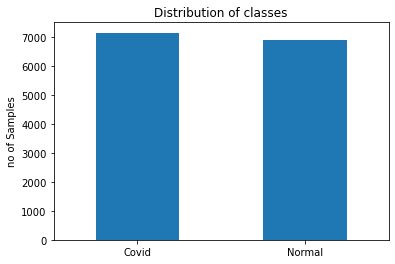

In [7]:
dataset_df["label"].value_counts().plot(kind='bar')
plt.xticks([0,1], ["Covid", "Normal"], rotation='horizontal')
plt.ylabel('no of Samples')
plt.title('Distribution of classes')
plt.show()

In [8]:
dataset_df["label"].value_counts()

0    7149
1    6893
Name: label, dtype: int64

In [9]:

dataset = dataset_df["concat data"].values
X = [img.tolist() for img in tqdm(dataset)]
X = np.array(X)
y = np.array(dataset_df["label"].values)
print("X shape", X.shape)
print("y shape", y.shape)


  0%|          | 0/14042 [00:00<?, ?it/s]

X shape (14042, 619)
y shape (14042,)


In [10]:
from sklearn import preprocessing
X_norm = preprocessing.normalize(X)

In [11]:
# change dimensions for training 
dataset_X = np.expand_dims(X_norm, axis=-1)
dataset_y = np.expand_dims(y, axis=-1)
print(" shape of the dataset after changing the dimension")
print("X : ", dataset_X.shape)
print("y : ", dataset_y.shape)

 shape of the dataset after changing the dimension
X :  (14042, 619, 1)
y :  (14042, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, shuffle=True, test_size=0.20, random_state=0)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.20, random_state=0)

In [22]:
X_train[1].shape

(619, 1)

In [14]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model_name = "Conv1D_resized_500"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))
    

In [16]:
BATCH_SIZE = 10
EPOCHS = 500
history = model.fit(
    X_train, y_train, 
    BATCH_SIZE, 
    EPOCHS, 
    validation_data=(X_val, y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/"+model_name+".h5")

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
899/899 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.6954WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000231E8B8ACA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

In [17]:
# test loss, test accuracy
accuracy = model.evaluate(X_test, y_test, batch_size=100, verbose=0)

In [18]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9430402517318726
Test loss 0.297277569770813


In [19]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
88/88 [==============================] - 0s 3ms/step


In [20]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.94      0.95      0.94      1395
      Normal       0.95      0.94      0.94      1414

    accuracy                           0.94      2809
   macro avg       0.94      0.94      0.94      2809
weighted avg       0.94      0.94      0.94      2809



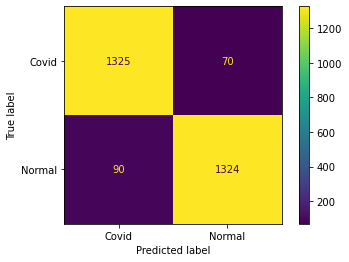

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()


## Model using just the Dense layer

In [22]:
model = Sequential()
model.add(Dense( 64, activation='relu', input_shape=X_train[0].shape))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model_name = "dense_resized_64_500"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [24]:
BATCH_SIZE = 10
EPOCHS = 500
history = model.fit(
    X_train, y_train, 
    BATCH_SIZE, 
    EPOCHS, 
    validation_data=(X_val, y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/"+model_name+".h5")

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
895/899 [============================>.] - ETA: 0s - loss: 0.6123 - accuracy: 0.6736WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000231DCD3CB88> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

In [25]:
# test loss, test accuracy
accuracy = model.evaluate(X_test, y_test, batch_size=100, verbose=0)
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9320042729377747
Test loss 0.31488239765167236


In [26]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["covid", "Normal"]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
88/88 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

       covid       0.94      0.92      0.93      1395
      Normal       0.92      0.94      0.93      1414

    accuracy                           0.93      2809
   macro avg       0.93      0.93      0.93      2809
weighted avg       0.93      0.93      0.93      2809

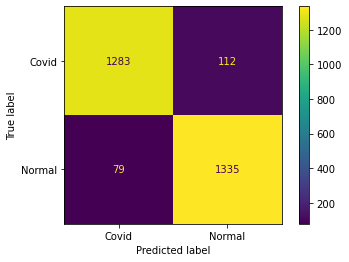

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
